**Microscopic SIR approach with simple contagion dynamics**

We model the migration in the microscopic level, i.e. modelling the state of every node at every time t and the efect of its neighbours.

PROS: understands neighbours. Maybe easy to adapt to complex contagion dynamics.
CONT: computational expensive. Normally, in real-world problems one does not have access that much information. 

In [1]:
import numpy as np
import networkx as nx
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
# load the graph and the real data
G = nx.read_gml("networks/migration_top_comm.gml")
timestamps = pd.read_csv("data/sliced_user_timestamps.csv", index_col=0)

In [3]:
# slice the timestamps to the users of the Top Community
graph_nodes = set(G.nodes())
timestamps['user'] = timestamps['user'].astype(str)
filtered_timestamps = timestamps[timestamps['user'].isin(graph_nodes)]

# get the real infection evolution
date_counts = filtered_timestamps['day'].value_counts().sort_index()
I_real = date_counts.cumsum()

# get the initial infected: Early-infected + infected at day 0
initial_infected = filtered_timestamps[filtered_timestamps["day"] == 0]["user"].tolist()

# max steps
max_steps = len(I_real) - 1

**One run with arbitrary parameters**

In [12]:
from src.models import sir_model_microscopic, sirs_model_microscopic

params1 = 0.005, 0.002
params2 = 0.005, 0.002, 0.01

S_sir, I_sir, R_sir, R0_sir = sir_model_microscopic(G, initial_infected, params1, max_steps)
S_sirs, I_sirs, R_sirs, R0_sirs = sirs_model_microscopic(G, initial_infected, params2, max_steps)

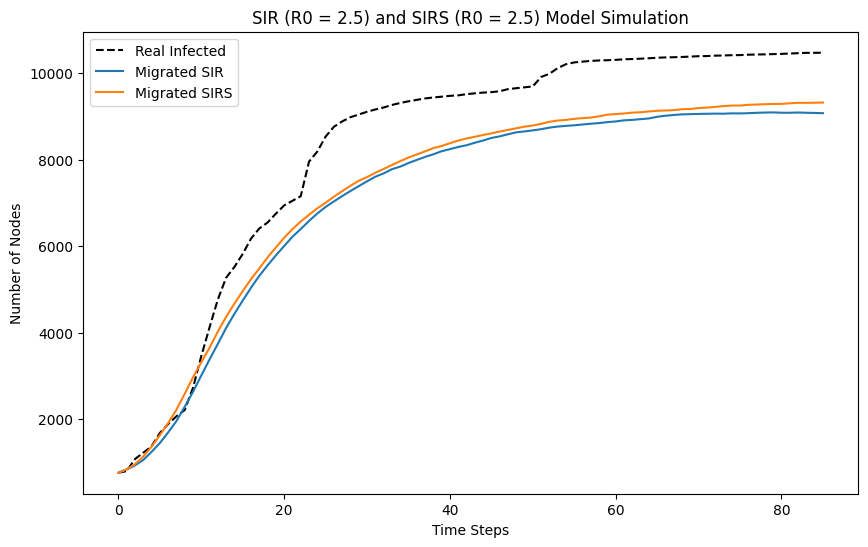

In [13]:
date_counts = filtered_timestamps['day'].value_counts().sort_index()

# Calculate the cumulative sum of the daily counts
cumulative_sum = date_counts.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(cumulative_sum.index, cumulative_sum.values, linestyle='--', color='black', label='Real Infected')
#plt.plot(S, label='Susceptible')
plt.plot(I_sir, label='Migrated SIR')
plt.plot(I_sirs, label='Migrated SIRS')
#plt.plot(R, label='Recovered')
plt.xlabel('Time Steps')
plt.ylabel('Number of Nodes')
plt.title('SIR (R0 = '+str(R0_sir)+') and SIRS (R0 = '+str(R0_sirs)+') Model Simulation')
plt.legend()
plt.show()

**Fitting the model. Finding the best parameters (SIRS)**

Loss (MSE) at iteration with params [0.006  0.0018 0.06  ]: 282434.0348837209
Loss (MSE) at iteration with params [0.0062 0.0018 0.06  ]: 272549.38372093026
Loss (MSE) at iteration with params [0.0062 0.002  0.06  ]: 283895.23255813954
Loss (MSE) at iteration with params [0.0062 0.0018 0.0602]: 246574.11627906977
Loss (MSE) at iteration with params [0.00626586 0.00172441 0.06037306]: 233912.23255813954
Loss (MSE) at iteration with params [0.00631042 0.0018803  0.06049016]: 293291.511627907
Loss (MSE) at iteration with params [0.00616869 0.00173733 0.06039283]: 286817.32558139536
Loss (MSE) at iteration with params [0.00640764 0.00158506 0.06035114]: 171483.13953488372
Loss (MSE) at iteration with params [0.00649996 0.00160323 0.06017465]: 202216.38372093023
Loss (MSE) at iteration with params [0.00646214 0.00166065 0.06038743]: 230996.22093023255
Loss (MSE) at iteration with params [0.00640267 0.00138609 0.06037077]: 164033.87209302327
Loss (MSE) at iteration with params [0.00630763 0.

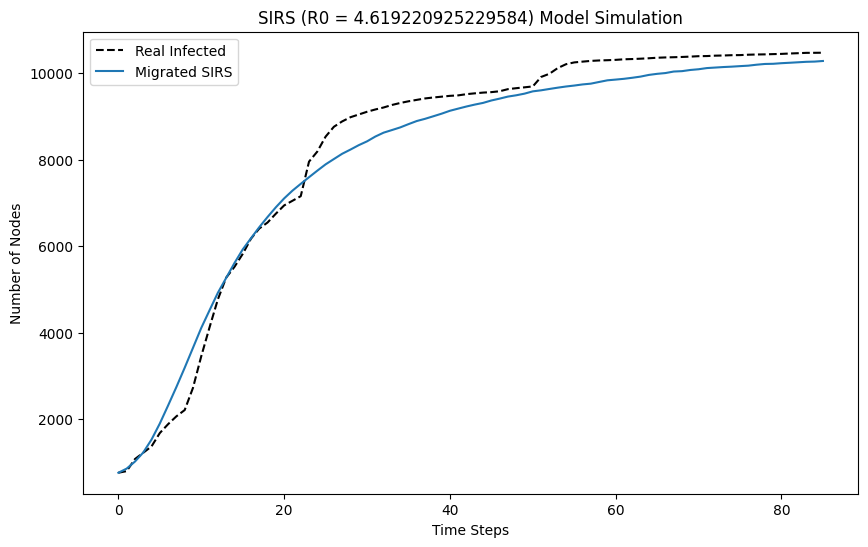

In [16]:
from src.models import sirs_model_microscopic, Micro_ParamTracker

 # fit the model to our data
initial_params = [0.006, 0.0018, 0.06]
options = {'maxiter': 20,  # Maximum number of iterations
           'rhobeg': 0.0002, # Initial stepsize
           'disp': True,    # Display convergence messages
           'maxiter': 50
 }
tracker = Micro_ParamTracker()

result = minimize(tracker.loss_micro, initial_params, args=(G, initial_infected, sirs_model_microscopic, I_real), method='COBYLA', options = options)     
S_sirs, I_sirs, R_sirs, R0_sirs = sirs_model_microscopic(G, initial_infected, tracker.best_params, max_steps)

plt.figure(figsize=(10, 6))
plt.plot(I_real.index, I_real.values, linestyle='--', color='black', label='Real Infected')
plt.plot(I_sirs, label='Migrated SIRS')
plt.xlabel('Time Steps')
plt.ylabel('Number of Nodes')
plt.title('SIRS (R0 = '+str(R0_sirs)+') Model Simulation')
plt.legend()
plt.show()